In [82]:
import subprocess
import time
import random
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Milvus
from langchain.agents import create_react_agent, AgentExecutor
from langchain.tools import Tool
from pymilvus import utility, Collection, connections

/Users/kyler/CodeStuff/Capstone/venv/lib/python3.10/site-packages/langchain/chains/api/base.py:57: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_community.utilities.requests import TextRequestsWrapper
/Users/kyler/CodeStuff/Capstone/venv/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:913: UserWarning: Mixing V1 models and V2 models (or constructs, like `TypeAdapter`) is not supported. Please upgrade `TextRequestsWrapper` to V2.
  warn(


In [66]:
SAMPLE_SIZE = 100

MILVUS_HOST = "localhost"
MILVUS_PORT = "19530"

COLLECTION_NAME = "medical_knowledge_base_v2"

In [67]:
def load_and_chunk(data_directory: str, chunk_size: int = 1000, chunk_overlap: int = 200):
    """Load PDFs from disk and split into text chunks."""
    loader = DirectoryLoader(
        data_directory,
        glob="**/*.pdf",
        loader_cls=PyMuPDFLoader
    )
    docs = loader.load()
    for doc in docs:
        doc.metadata["source"] = Path(doc.metadata["source"]).name
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunks = splitter.split_documents(docs)
    print(f"Loaded {len(docs)} pages → {len(chunks)} chunks")
    return chunks

In [68]:
data_dir = "/Users/Kyler/Codestuff/Capstone/papers/"
chunks = load_and_chunk(data_dir)
total_chunks = len(chunks)

Loaded 7520 pages → 20021 chunks


In [69]:
total_chunks = len(chunks)
sampled_chunks = random.sample(chunks, SAMPLE_SIZE)

In [70]:
connections.connect(
        alias="default",
        host=MILVUS_HOST,
        port=MILVUS_PORT
    )

In [71]:
embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
existing = utility.list_collections()
print("Existing collections:", existing)

if COLLECTION_NAME not in existing:
    vector_store = Milvus.from_documents(
        documents=chunks,
        embedding=embedder,
        collection_name=COLLECTION_NAME,
        connection_args={"host": MILVUS_HOST, "port": MILVUS_PORT}
    )
else:
    vector_store = Milvus(
        embedding_function=embedder,
        collection_name=COLLECTION_NAME,
        connection_args={"host": MILVUS_HOST, "port": MILVUS_PORT}
    )
    col = Collection(COLLECTION_NAME)
    print(f"Collection '{COLLECTION_NAME}' already contains {col.num_entities} chunks")

retriever = vector_store.as_retriever(search_kwargs={"k": 5})

Existing collections: ['medical_knowledge_base_v1']


In [72]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.7)
prompt = PromptTemplate.from_template(
    "Generate one concise question answered by this passage:\n\n{text}\n\nQuestion:"
)
questions = []
for chunk in tqdm(sampled_chunks, desc="Generating questions"):
    resp = llm.invoke(prompt.format(text=chunk.page_content))
    q = resp.content.strip()
    questions.append({"question": q, "source": chunk.metadata["source"]})
    print(f"Q from {chunk.metadata['source']}: '{q}'")

Generating questions:   0%|          | 0/100 [00:00<?, ?it/s]

Q from Diagnostic Imaging_ Gastrointestinal ( PDFDrive ).pdf: 'What is the recommended imaging tool for diagnosing acute viral hepatitis?'
Q from CT and MRI of the Whole Body, 2-Volume Set, 6e, Volume I ( PDFDrive ).pdf: 'What imaging features characterize a desmoplastic infantile ganglioglioma (DIG) on MRI?'
Q from Gastrointestinal Imaging_ The Requisites (Requisites in Radiology) 3rd ed ( PDFDrive ).pdf: 'What is the most common cause of free intraperitoneal air in hospitalized patients?'
Q from Diagnostic Imaging_ Gastrointestinal ( PDFDrive ).pdf: 'What are the common imaging features of a solid and pseudopapillary neoplasm (SPEN) in the pancreas?'
Q from CT and MRI of the Whole Body, 2-Volume Set, 6e, Volume I ( PDFDrive ).pdf: 'What roles does Gln play in the human brain according to the passage?'
Q from Gastrointestinal Imaging_ The Requisites (Requisites in Radiology) 3rd ed ( PDFDrive ).pdf: 'How can liver density measurements help determine the cause of cardiac dysrhythmias d

In [75]:
hits = []
for item in questions:
    docs = retriever.get_relevant_documents(item["question"])
    sources = [d.metadata["source"] for d in docs]
    hit = item["source"] in sources
    hits.append(hit)
    print(f"Retrieved {sources} → Hit: {hit}")

recall_at_5 = sum(hits) / len(hits)
print(f"Recall@5: {recall_at_5:.2f}")

Retrieved ['Diagnostic Imaging_ Gastrointestinal ( PDFDrive ).pdf', 'Diagnostic Imaging_ Gastrointestinal ( PDFDrive ).pdf', 'Diagnostic Imaging_ Gastrointestinal ( PDFDrive ).pdf', 'CT and MRI of the Whole Body, 2-Volume Set, 6e, Volume I ( PDFDrive ).pdf', 'Liver imaging _ MRI with CT correlation ( PDFDrive ).pdf'] → Hit: True
Retrieved ['CT and MRI of the Whole Body, 2-Volume Set, 6e, Volume I ( PDFDrive ).pdf', 'CT and MRI of the Whole Body, 2-Volume Set, 6e, Volume I ( PDFDrive ).pdf', 'CT and MRI of the Whole Body, 2-Volume Set, 6e, Volume I ( PDFDrive ).pdf', 'CT and MRI of the Whole Body, 2-Volume Set, 6e, Volume I ( PDFDrive ).pdf', 'CT and MRI of the Whole Body, 2-Volume Set, 6e, Volume I ( PDFDrive ).pdf'] → Hit: True
Retrieved ['Gastrointestinal Imaging_ The Requisites (Requisites in Radiology) 3rd ed ( PDFDrive ).pdf', 'Gastrointestinal Imaging_ The Requisites (Requisites in Radiology) 3rd ed ( PDFDrive ).pdf', 'Gastrointestinal Imaging_ The Requisites (Requisites in Radio

Recall@1: 0.68
Recall@3: 0.86
Recall@5: 0.88
Recall@10: 0.95
Recall@15: 0.96
Recall@20: 0.96


Text(0.5, 1.0, 'Retrieval Performance')

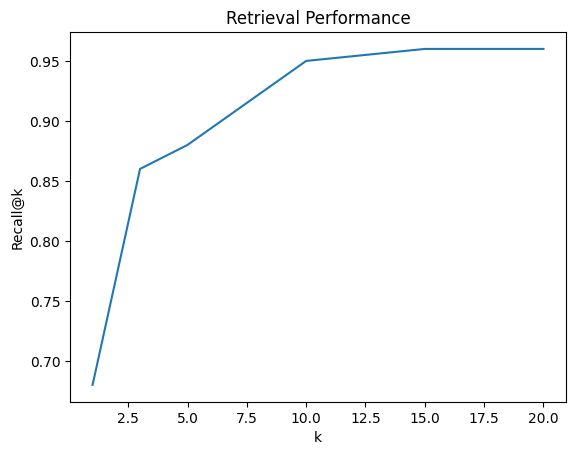

In [79]:
ks = [1, 3, 5, 10, 15, 20]
recalls = []
for k in ks:
    retr = vector_store.as_retriever(search_kwargs={"k": k})
    hits_k = [
        (item["source"] in [d.metadata["source"] for d in retr.get_relevant_documents(item["question"])])
        for item in questions
    ]
    recalls.append(sum(hits_k) / len(hits_k))

for k, recall in zip(ks, recalls):
    print(f"Recall@{k}: {recall:.2f}")

plt.plot(ks, recalls)
plt.xlabel("k")
plt.ylabel("Recall@k")
plt.title("Retrieval Performance")